In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Cleaned Data ---
# This file was created by '01_data_preparation.ipynb'
DATA_FILE = 'df_model_cleaned.parquet'

try:
    df_model = pd.read_parquet(DATA_FILE)
    print("Cleaned data loaded successfully.")
    print(f"Total rows: {len(df_model)}, Total columns: {len(df_model.columns)}")
except FileNotFoundError:
    print(f"Error: The file {DATA_FILE} was not found.")
    print("Please run the first notebook '01_data_preparation.ipynb' to create it.")

# Check the data
print(df_model.head())

# .info() is important to check that the datetime index was loaded correctly
print("\n--- DataFrame Info ---")
df_model.info()

Cleaned data loaded successfully.
Total rows: 50282, Total columns: 25
                           AT_load_actual_entsoe_transparency  \
datetime                                                        
2015-01-05 22:00:00+00:00                              6182.0   
2015-01-05 23:00:00+00:00                              5523.0   
2015-01-06 00:00:00+00:00                              5220.0   
2015-01-06 01:00:00+00:00                              5015.0   
2015-01-06 02:00:00+00:00                              4868.0   

                           AT_solar_generation_actual  \
datetime                                                
2015-01-05 22:00:00+00:00                         0.0   
2015-01-05 23:00:00+00:00                         0.0   
2015-01-06 00:00:00+00:00                         0.0   
2015-01-06 01:00:00+00:00                         0.0   
2015-01-06 02:00:00+00:00                         0.0   

                           AT_wind_onshore_generation_actual  \
datetime 

In [2]:
# --- 2. Define Target (y) and Features (X) ---
# (This was Cell 8)

# We will build our first model to predict the load for France (FR)
TARGET_COLUMN = 'FR_load_actual_entsoe_transparency'

# 'y' is our target variable (what we want to predict)
y = df_model[TARGET_COLUMN]

# 'X' is our set of features (what we use to predict)
# It's all columns EXCEPT the target column
X = df_model.drop(columns=[TARGET_COLUMN])

print(f"Target (y) column: {y.name}")
print(f"Feature (X) columns (example): {list(X.columns[:5])}...")
print(f"Total features: {len(X.columns)}") # Should be 24

Target (y) column: FR_load_actual_entsoe_transparency
Feature (X) columns (example): ['AT_load_actual_entsoe_transparency', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual']...
Total features: 24


In [3]:
# --- 3. Train-Test Split (Time Series) ---
# (This was Cell 9)

# CRITICAL: We cannot shuffle time series data.
# We must train on the past and test on the future.
# We will use data before 2020 to train, and data from 2020 to test.

# Create the training set (all data before Jan 1, 2020)
X_train = X[X.index < '2020-01-01']
y_train = y[y.index < '2020-01-01']

# Create the test set (all data from Jan 1, 2020 onwards)
X_test = X[X.index >= '2020-01-01']
y_test = y[y.index >= '2020-01-01']

print("--- Data Split ---")
print(f"Training data points (X_train): {len(X_train)}")
print(f"Test data points (X_test): {len(X_test)}")
print(f"Training data starts: {X_train.index.min()}")
print(f"Training data ends: {X_train.index.max()}")
print(f"Test data starts: {X_test.index.min()}")
print(f"Test data ends: {X_test.index.max()}")

--- Data Split ---
Training data points (X_train): 43706
Test data points (X_test): 6576
Training data starts: 2015-01-05 22:00:00+00:00
Training data ends: 2019-12-31 23:00:00+00:00
Test data starts: 2020-01-01 00:00:00+00:00
Test data ends: 2020-09-30 23:00:00+00:00


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 4. Train First Model: Linear Regression (Baseline) ---

# 1. Create an instance of the model
# We create the 'empty' model object first
model_lr = LinearRegression()

# 2. Train the model
# .fit() is the 'training' step. It learns the patterns
# from the training data (X_train) to predict the target (y_train).
print("Training the Linear Regression model...")
model_lr.fit(X_train, y_train)
print("Model trained successfully.")

# 3. Make predictions on the test set
# We use the trained model to predict the load for 2020 (X_test)
y_pred_lr = model_lr.predict(X_test)

# 4. Evaluate the model's performance
# We compare the predictions (y_pred_lr) with the real values (y_test)
print("\n--- Model Evaluation (Test Set) ---")

# Mean Absolute Error (MAE): The average error in MW.
# (e.g., "On average, the model is off by X MW")
mae = mean_absolute_error(y_test, y_pred_lr)
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")

# Root Mean Squared Error (RMSE): Similar to MAE, but penalizes large errors more.
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")

# R-squared (R²): How much of the variation the model explains (1.0 = perfect)
r2 = r2_score(y_test, y_pred_lr)
print(f"R-squared (R²) Score: {r2:.4f}")

Training the Linear Regression model...
Model trained successfully.

--- Model Evaluation (Test Set) ---
Mean Absolute Error (MAE): 4052.58 MW
Root Mean Squared Error (RMSE): 5135.00 MW
R-squared (R²) Score: 0.7732



Plotting first week of 2020 predictions...


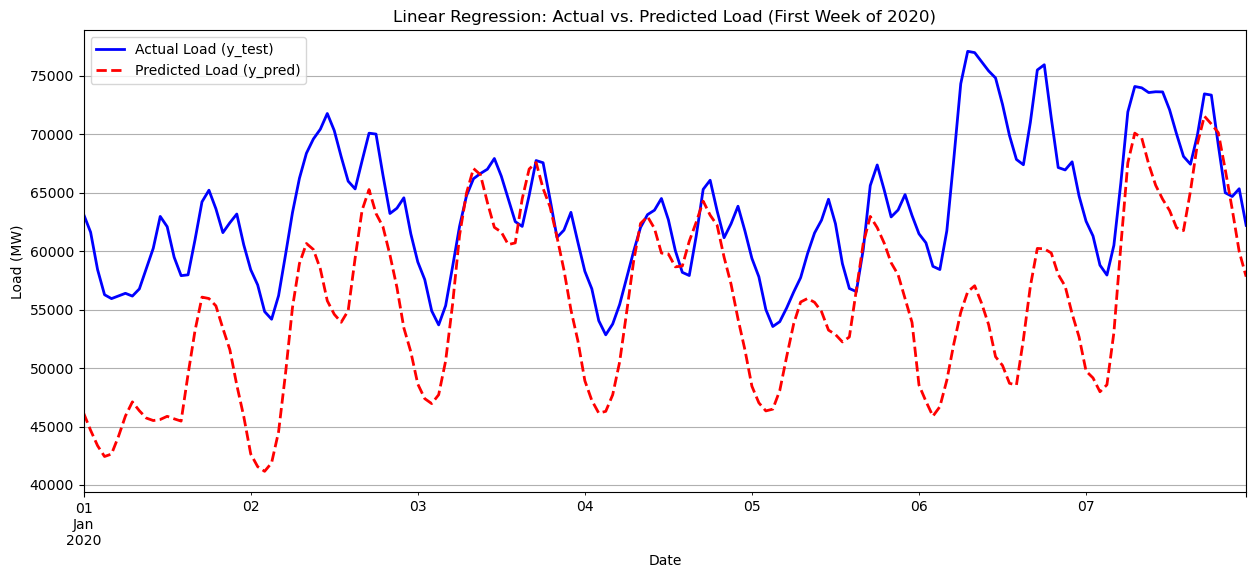

In [5]:
# --- 5. Visualize Predictions vs. Actuals ---

# Create a new DataFrame to hold the test results
df_results = pd.DataFrame({
    'Actual_Load': y_test,
    'Predicted_Load': y_pred_lr
})

# Set the index from y_test (which is the datetime index)
df_results.index = y_test.index

# Plot the first week of 2020 (168 hours)
# We use .iloc[] to select rows by position
df_results_sample = df_results.iloc[:168]

print("\nPlotting first week of 2020 predictions...")
plt.figure(figsize=(15, 6))

df_results_sample['Actual_Load'].plot(
    label='Actual Load (y_test)', 
    color='blue', 
    linewidth=2
)
df_results_sample['Predicted_Load'].plot(
    label='Predicted Load (y_pred)', 
    color='red', 
    linestyle='--', 
    linewidth=2
)

plt.title('Linear Regression: Actual vs. Predicted Load (First Week of 2020)')
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()